# AdaBoost

In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt

Load MNIST

In [2]:
def load_images(filename):
    with open(filename, 'rb') as f:
        _, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows * cols)
    return images.T  # Now shape = 784 x N

def load_labels(filename):
    with open(filename, 'rb') as f:
        _, _ = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

PCA 

In [3]:
def compute_PCA(X, variance_retained=0.95, n_components=-1):
    total_samples = X.shape[1]
    Xc = X - train_set_global_mean
    covariance_S = np.dot(Xc, Xc.T) / (total_samples - 1)

    eigenvalues, eigenvectors = np.linalg.eigh(covariance_S)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    total_variance = np.sum(eigenvalues)
    required_variance = total_variance * variance_retained
    psum, index = 0, 0
    while index < len(eigenvalues) and psum < required_variance:
        psum += eigenvalues[index]
        index += 1
    p = index

    if n_components != -1:
        p = n_components

    U_p = eigenvectors[:, :p]
    return U_p, p

Decision Stump

In [4]:
def train_stump(X, y, weights):
    n_features, n_samples = X.shape
    best_loss = float('inf')
    best_stump = {}

    for feature in range(n_features):
        values = X[feature, :]
        cuts = np.linspace(values.min(), values.max(), 5)[1:-1]  # 3 cuts

        for cut_values in cuts:
            for types in [1, -1]:
                preds = types * np.sign(values - cut_values)
                preds[preds == 0] = 1  # Treat 0 as +1

                # Use weighted classification error
                misclassified = preds != y
                loss = np.sum(weights[misclassified]) / np.sum(weights)

                if loss < best_loss:
                    best_loss = loss
                    best_stump = {
                        'feature': feature,
                        'cut_values': cut_values,
                        'types': types,
                        'predictions': preds
                    }
    return best_stump, best_loss

Function to Train Adaboost 

In [5]:
def adaboost_predict(X, classifiers, betas):
    n_samples = X.shape[1]
    final_pred = np.zeros(n_samples)

    for clf, beta in zip(classifiers, betas):
        feature = clf['feature']
        cut_values = clf['cut_values']
        types = clf['types']

        preds = types * np.sign(X[feature, :] - cut_values)
        preds[preds == 0] = 1
        final_pred += beta * preds

    return final_pred
    
def adaboost_train(X, y, rounds):
    n_samples = X.shape[1]
    weights = np.full(n_samples, 1 / n_samples)
    classifiers = []
    betas = []
    train_errors = []
    losses = []


    for t in range(rounds):
        stump, round_loss = train_stump(X, y, weights)
        round_loss = max(round_loss, 1e-10)  # avoid division by zero
        beta = 0.5 * np.log((1 - round_loss) / round_loss)

        preds = stump['predictions']
        weights *= np.exp(-beta * y * preds)    # weight updation e^-beta, e^beta
        weights /= np.sum(weights)

        classifiers.append(stump)
        betas.append(beta)

        ensemble_pred = adaboost_predict(X, classifiers, betas)
        loss = np.mean(np.exp(-y * ensemble_pred))
        losses.append(loss)

        y_pred = np.sign(ensemble_pred)
        y_pred[y_pred == 0] = 1
        train_error = np.mean(y_pred != y)
        train_errors.append(train_error)

        # print(f"Round {t+1}: Error={error:.4f}, Beta={beta:.4f}, Train Error={train_error:.4f}")

    return classifiers, betas, train_errors, losses



Load and preprocess data

In [6]:
X_train_raw = load_images("TrainSet/train-images.idx3-ubyte")  # shape = 784 x N
y_train_raw = load_labels("TrainSet/train-labels.idx1-ubyte")

X_test_raw = load_images("TestSet/t10k-images.idx3-ubyte")
y_test_raw = load_labels("TestSet/t10k-labels.idx1-ubyte")

# Select classes 0 and 1
def select_digits(X, y, d1=0, d2=1, max_each=1000):
    idx1 = np.where(y == d1)[0][:max_each]
    idx2 = np.where(y == d2)[0][:max_each]
    X_sel = np.hstack((X[:, idx1], X[:, idx2]))
    y_sel = np.hstack((np.ones(len(idx1)), np.zeros(len(idx2))))
    return X_sel, y_sel

def select_digits_random(X, y, d1=0, d2=1, max_each=1000):
    idx1 = np.where(y == d1)[0]
    idx2 = np.where(y == d2)[0]
    
    idx1 = np.random.choice(idx1, max_each, replace=False)
    idx2 = np.random.choice(idx2, max_each, replace=False)
    
    X_sel = np.hstack((X[:, idx1], X[:, idx2]))
    y_sel = np.hstack((np.ones(len(idx1)), np.zeros(len(idx2))))
    return X_sel, y_sel

def select_all_digits(X, y, d1=0, d2=1):
    idx = np.where((y == d1) | (y == d2))[0]
    X_sel = X[:, idx]
    y_sel = np.where(y[idx] == d1, 1, 0)
    return X_sel, y_sel

# X_train, y_train = select_digits(X_train_raw, y_train_raw)
X_train, y_train = select_digits_random(X_train_raw, y_train_raw)
y_train = 2 * y_train - 1  # Convert to {-1, +1}

X_test, y_test = select_all_digits(X_test_raw, y_test_raw)
y_test = 2 * y_test - 1


# Normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

Apply PCA

In [7]:
train_set_global_mean = np.mean(X_train, axis=1, keepdims=True)
U_p, p = compute_PCA(X_train, n_components=5)

X_train=X_train-train_set_global_mean
X_test=X_test-train_set_global_mean

X_train_pca = U_p.T @ X_train    # shape = 5 x 2000
X_test_pca = U_p.T @ X_test      # shape = 5 x N_test

Train AdaBoost 

In [8]:
rounds = 200
classifiers, betas, train_errors, train_losses = adaboost_train(X_train_pca, y_train, rounds)

Test Loss

In [9]:
def adaboost_train_with_test_loss(X, y, X_test, y_test, rounds):
    n_samples = X.shape[1]
    weights = np.full(n_samples, 1 / n_samples)
    classifiers = []
    betas = []
    train_errors = []
    train_losses = []
    test_losses = []  # To track test loss
    
    for t in range(rounds):
        stump, round_loss = train_stump(X, y, weights)
        round_loss = max(round_loss, 1e-10)  # avoid division by zero
        beta = 0.5 * np.log((1 - round_loss) / round_loss)

        preds = stump['predictions']
        weights *= np.exp(-beta * y * preds)    # weight updation e^-beta, e^beta
        weights /= np.sum(weights)

        classifiers.append(stump)
        betas.append(beta)

        # Train set predictions
        ensemble_pred_train = adaboost_predict(X, classifiers, betas)
        train_loss = np.mean(np.exp(-y * ensemble_pred_train))
        train_losses.append(train_loss)
        
        y_pred_train = np.sign(ensemble_pred_train)
        y_pred_train[y_pred_train == 0] = 1
        train_error = np.mean(y_pred_train != y)
        train_errors.append(train_error)

        # Test set predictions
        ensemble_pred_test = adaboost_predict(X_test, classifiers, betas)
        test_loss = np.mean(np.exp(-y_test * ensemble_pred_test))
        test_losses.append(test_loss)

    return classifiers, betas, train_errors, train_losses, test_losses


# Train AdaBoost with test loss tracking
classifiers, betas, train_errors_with_test, train_losses_with_test, test_losses = adaboost_train_with_test_loss(X_train_pca, y_train, X_test_pca, y_test, rounds)

Predict Test set

In [10]:
test_preds = adaboost_predict(X_test_pca, classifiers, betas)
test_accuracy = np.mean(np.sign(test_preds) == y_test)
print(f"Final Test Accuracy on MNIST 0 vs 1: {test_accuracy * 100:.2f}%")


Final Test Accuracy on MNIST 0 vs 1: 99.57%


# Plots 

Plot Train Loss

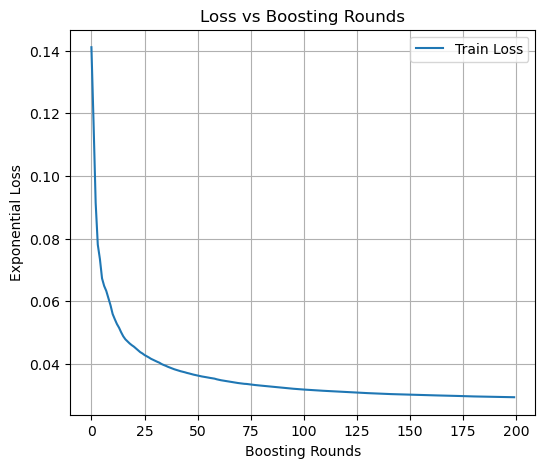

In [11]:
plt.figure(figsize=(6, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel("Boosting Rounds")
plt.ylabel("Exponential Loss")
plt.title("Loss vs Boosting Rounds")
plt.grid(True)
plt.legend()
plt.show()

Plot Test Loss

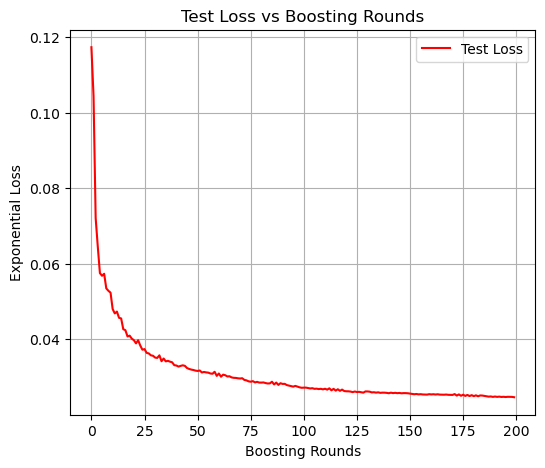

In [12]:
plt.figure(figsize=(6, 5))
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel("Boosting Rounds")
plt.ylabel("Exponential Loss")
plt.title("Test Loss vs Boosting Rounds")
plt.grid(True)
plt.legend()
plt.show()

Plot Train Error

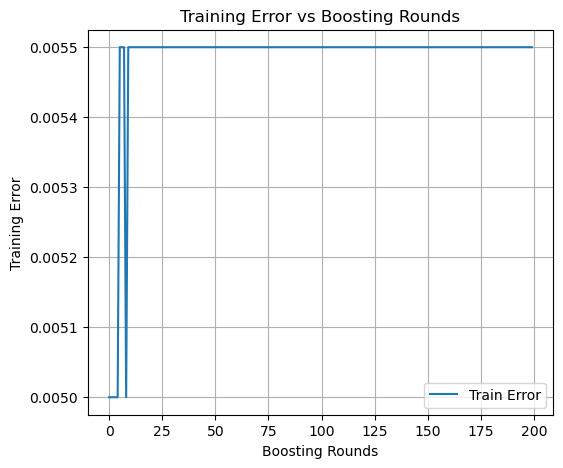

In [13]:
plt.figure(figsize=(6, 5))
plt.plot(train_errors, label='Train Error')
plt.xlabel("Boosting Rounds")
plt.ylabel("Training Error")
plt.title("Training Error vs Boosting Rounds")
plt.grid(True)
plt.legend()
plt.show()